In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import drive
import numpy as np

In [16]:
# Montar Google Drive
drive.mount('/content/drive')

# Definir la ruta al archivo en Google Drive
file_path = '/content/drive/My Drive/dataset_cve_mun_(1).csv'

# Cargar el dataset
dataset = pd.read_csv(file_path)

# Definir las variables predictoras y la variable objetivo
X = dataset.drop(columns=["CVE_MUN", "Diferencia_Temperatura"])
y = dataset["Diferencia_Temperatura"]

# Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#Se definen 3 modelos y se comprobará el desempeño de cada uno para definir el mejor
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

In [18]:
# Definir función de evaluación
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Predecir en el conjunto de prueba
    predictions = model.predict(X_test)

    # Calcular métricas de evaluación
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Validación cruzada
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())

    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2,
        "CV_RMSE": cv_rmse
    }

In [19]:
# Evaluar los modelos y almacenar los resultados
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train, y_train, X_test, y_test)

# Mostrar los resultados en un DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

                        MSE      RMSE       MAE        R²   CV_RMSE
Linear Regression  7.392741  2.718960  1.904160 -4.365374  3.336876
Decision Tree      3.859445  1.964547  1.639120 -1.801041  5.547330
Random Forest      2.717510  1.648487  1.352381 -0.972267  3.409242


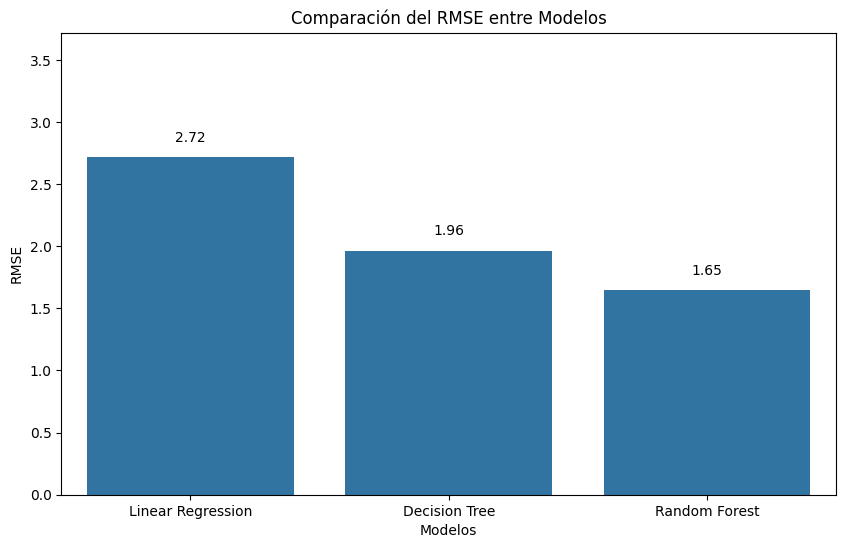

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# El modelo con el menor valor de RMSE es el que tiene el mejor desempeño en este contexto de regresión.
metric_to_plot = 'RMSE'

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df[metric_to_plot])
plt.title(f'Comparación del {metric_to_plot} entre Modelos')
plt.xlabel('Modelos')
plt.ylabel(metric_to_plot)
plt.ylim(0, results_df[metric_to_plot].max() + 1)  # Ajustar el límite del eje Y para una mejor visualización

# Mostrar el valor exacto sobre cada barra
for index, value in enumerate(results_df[metric_to_plot]):
    plt.text(index, value + 0.1, round(value, 2), ha='center', va='bottom')

plt.show()


In [22]:
# Verificar el subajuste o sobreajuste en cada modelo
# Evaluar el rendimiento del modelo en los conjuntos de entrenamiento y prueba
def evaluate_overfitting(model, X_train, y_train, X_test, y_test):
    # Error en el conjunto de entrenamiento
    train_predictions = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))

    # Error en el conjunto de prueba
    test_predictions = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

    return train_rmse, test_rmse

# Evaluar todos los modelos
overfitting_results = {}
for name, model in models.items():
    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)

    # Calcular el RMSE en entrenamiento y prueba
    train_rmse, test_rmse = evaluate_overfitting(model, X_train, y_train, X_test, y_test)
    overfitting_results[name] = {
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Difference': test_rmse - train_rmse
    }

# Mostrar los resultados
overfitting_df = pd.DataFrame(overfitting_results).T
print(overfitting_df)

                     Train RMSE  Test RMSE  Difference
Linear Regression  5.286551e-15   2.718960    2.718960
Decision Tree      0.000000e+00   1.964547    1.964547
Random Forest      1.378085e+00   1.648487    0.270403


Para el modelo que se elegió por la interpretación de desempeño **"Random Forest"**, La diferencia entre el RMSE de los datos de prueba y el RMSE de los datos de entrenamiento es muy baja, lo cual sugiere que este modelo generaliza bien y tiene un buen desempeño tanto en el conjunto de entrenamiento como en el conjunto de prueba. Una diferencia tan baja indica que el modelo no está sobreajustando, y tampoco está subajustando. Esto se debe a que Random Forest utiliza múltiples árboles, lo cual ayuda a suavizar las predicciones y evitar el sobreajuste.